# C.1.2 Semivariogram Regularization

## Table of Contents:

1. Prepare areal and point data,
2. Set semivariogram parameters,
3. Perform regularization,
4. Visualize regularized semivariogram and analyze algorithm performance,
5. Export semivariogram to json.

## Introduction

We will learn how to regularize a semivariogram of a dataset that consists of irregularly shaped polygons. The procedure of the semivariogram regularization is described here: (1) Goovaerts P., Kriging and Semivariogram Deconvolution in the Presence of Irregular Geographical Units, Mathematical Geology 40(1), 101-128, 2008.

The main idea is to retrieve the point support semivariogram from the semivariogram of blocks of different shapes and sizes. This is the case in the mining industry, where aggregated blocks are deconvoluted into smaller units, and in epidemiology, where data is aggregated over big administrative units. Or in ecology, where species observations are aggregated over areas or time windows.

In this tutorial, we use block data of Breast Cancer incidence rates in Northeastern counties of the U.S. and U.S. Census 2010 data for population blocks.

> The breast cancer rates data and the point support population counts are in the geopackage in a directory: `samples/regularization/cancer_data.gpkg`.

## Import packages

In [1]:
from pyinterpolate import build_experimental_variogram, Blocks, PointSupport, Deconvolution

## 1) Prepare areal and point data

Data structures for semivariogram regularization are rather complex, and that's why **Pyinterpolate** has classes to prepare this data for processing. There are two structures:

1. `Blocks()`: stores polygon and block data, transforms it, and retrieves centroids,
2. `PointSupport()`: performs spatial joins between polygons and points support data and manages internal indexing of those datasets.

A researcher can prepare data manually - the `Deconvolution` class processes `Dict`, `numpy array`, or `DataFrame` types of objects. For more data types and how to prepare them, we can look at the [API documentation](https://pyinterpolate.readthedocs.io/en/latest/api/datatypes/core.html).

In [2]:
DATASET = 'samples/regularization/cancer_data.gpkg'
OUTPUT = 'samples/regularization/regularized_variogram.json'
POLYGON_LAYER = 'areas'
POPULATION_LAYER = 'points'
POP10 = 'POP10'
GEOMETRY_COL = 'geometry'
POLYGON_ID = 'FIPS'
POLYGON_VALUE = 'rate'

In [3]:
blocks = Blocks()
blocks.from_file(DATASET, value_col=POLYGON_VALUE, index_col=POLYGON_ID, layer_name=POLYGON_LAYER)

point_support = PointSupport()
point_support.from_files(point_support_data_file=DATASET,
                         blocks_file=DATASET,
                         point_support_geometry_col=GEOMETRY_COL,
                         point_support_val_col=POP10,
                         blocks_geometry_col=GEOMETRY_COL,
                         blocks_index_col=POLYGON_ID,
                         use_point_support_crs=True,
                         point_support_layer_name=POPULATION_LAYER,
                         blocks_layer_name=POLYGON_LAYER)

ERROR 1: PROJ: proj_create_from_database: Open of /home/szymon/miniconda3/envs/pyinterpolate38/share/proj failed


## 2) Set semivariogram parameters

Now, we must set parameters for the areal semivariogram AND point semivariogram. It is essential to understand data well to set the variogram parameters properly. That's why you should always check the experimental semivariograms of block data and its point support. We do it for prepared areal and point datasets.

The *step size* and the *maximum search radius* parameters depend on the block data. But we should check the point's semivariogram too. We won't create meaningful results if point support data is spatially independent.

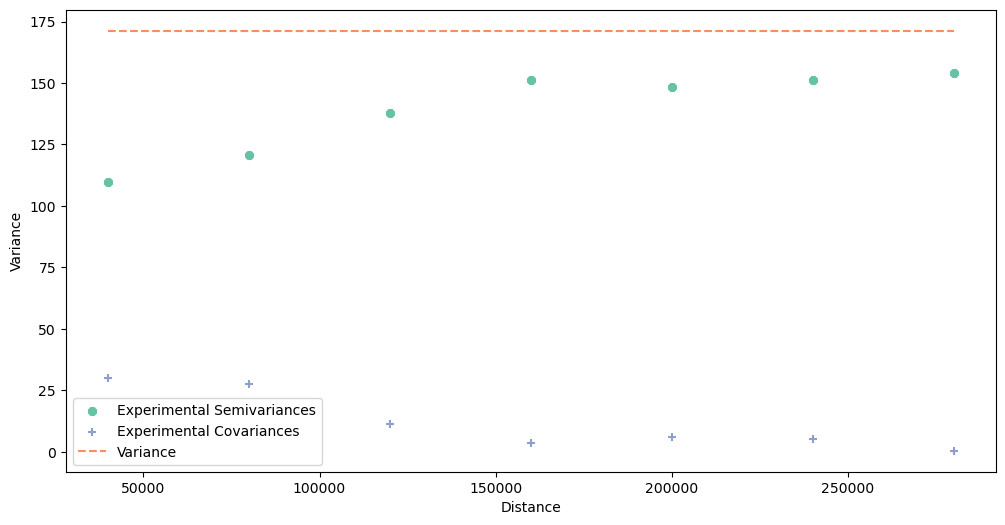

In [4]:
# Check experimental semivariogram of areal data - this cell may be run multiple times 
# before you find optimal parameters

maximum_range = 300000
step_size = 40000

dt = blocks.data[[blocks.cx, blocks.cy, blocks.value_column_name]]  # x, y, val
exp_semivar = build_experimental_variogram(input_array=dt, step_size=step_size, max_range=maximum_range)

# Plot experimental semivariogram

exp_semivar.plot()

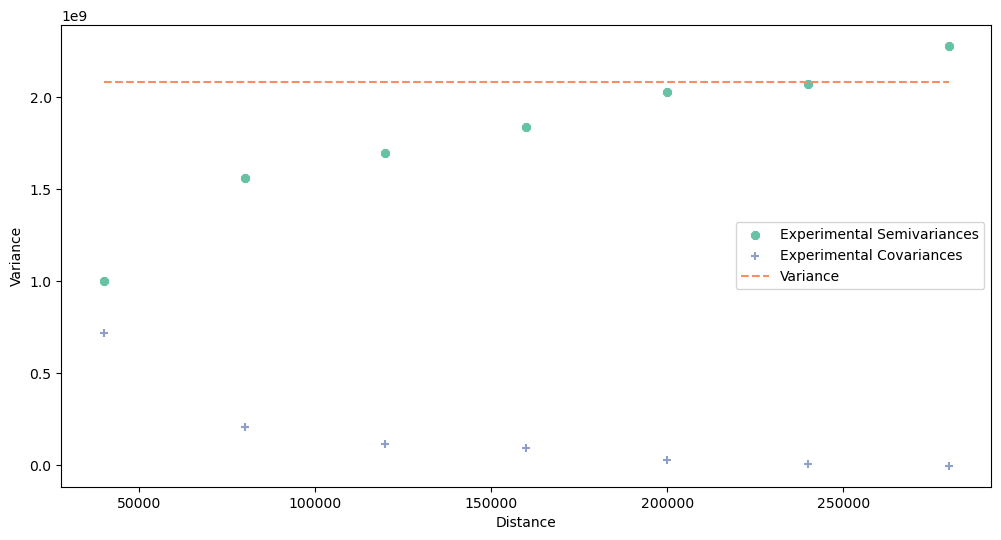

In [5]:
# Check experimental semivariogram of point data - this cell may be run multiple times 
# before you find optimal parameters

maximum_point_range = 300000
step_size_points = 20000


pt = point_support.point_support[[point_support.x_col, point_support.y_col, point_support.value_column]].values
exp_semivar = build_experimental_variogram(input_array=pt, step_size=step_size, max_range=maximum_range)

# Plot experimental semivariogram

exp_semivar.plot()

We see that block and point support variograms follow a spatial-dependency pattern. In this case, we can move to the next step - deconvolution. The next step is to create the `Deconvolution` object. We have multiple parameters to choose from, and it is hard to find the best fit initially, so try to avoid multiple loops because it is time-consuming.

The program is designed to first `fit()` the model and later to `transform()` it. There is a way to perform both steps simultaneously with the `fit_transform()` method. However, I encourage you to divide the process into two parts because transformation can take a long time to end. It is better to check how the model behaves after the first iteration (`fit()`) rather than wait until the end of processing.

When you `fit()` a model, you have multiple parameters to control, but only a few are necessary for regular purposes (**in bold**):
- **agg_dataset**: Blocks with aggregated data. `Blocks()` class object or `GeoDataFrame` and `DataFrame` with columns: `centroid.x, centroid.y, ds, index` or `numpy array`: `[[block index, centroid x, centroid y, value]]`.
- **point_support_dataset** : `PointSupport()` object, or `Dict`: `{block id: [[point x, point y, value]]}`, or `numpy array`: `[[block id, x, y, value]]`, or `DataFrame` and `GeoDataFrame`: `columns={x, y, ds, index}`.
- **agg_step_size** : Step size between lags.
- **agg_max_range** : Maximal distance of analysis.
- **agg_nugget** : The nugget of semivariogram. We will set it to 0.
- *agg_direction* : Direction of semivariogram, values from 0 to 360 degrees.
- *agg_tolerance* : (see docs).
- **variogram_weighting_method** : Method used to weight error at a given lags. Available methods:
  * equal: no weighting,
  * **closest**: Lags at a close range have bigger weights,
  * distant: lags that further away have bigger weights,
  * dense: error is weighted by the number of point pairs within a lag - more pairs, smaller weight.
- **model_name**: the name of the semivariogram function. Two terms aggregate multiple models: `all` and `safe`, and the latter is recommended to use.
- **model_types** : semivariogram model types to test. You can pass here a list of theoretical models.

We will weight lags, and we do not store semivariograms and semivariogram models.

After fitting, we perform `transform()`. This function has few parameters to control the regularization process, but we leave them as default with one exception: we set the **max_iters** parameter to 5.

This process of fitting and transforming takes some time, so it's a good idea to run it and do something else...

## 3) Regularize semivariogram

In [6]:
reg_mod = Deconvolution(verbose=True)

In [7]:
reg_mod.fit(agg_dataset=blocks,
            point_support_dataset=point_support,
            agg_step_size=step_size,
            agg_max_range=maximum_range,
            agg_nugget=0.,
            variogram_weighting_method='closest',
            model_name='safe')

Regularization fit process starts
Regularization fit process ends


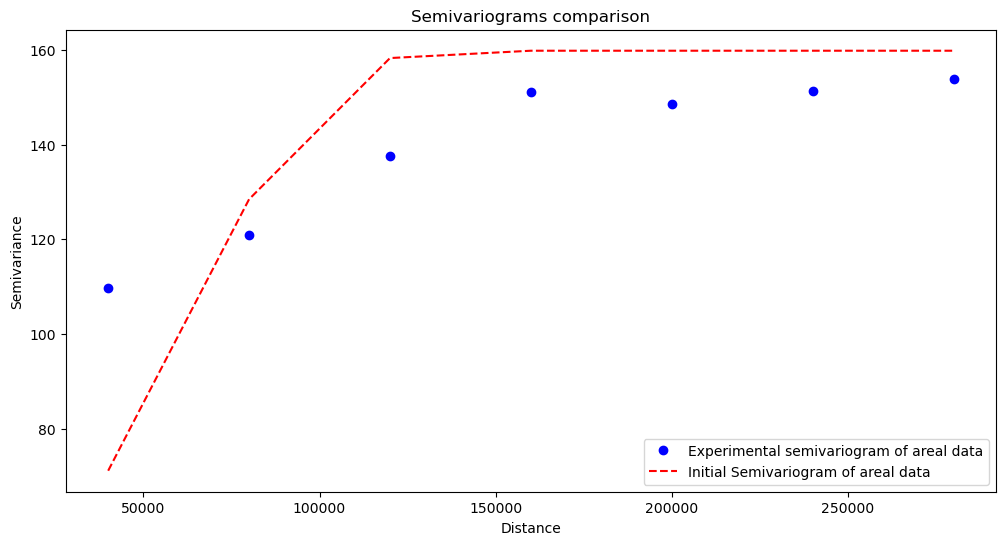

In [8]:
# Check initial experimental, theoretical and regularized semivariograms

reg_mod.plot_variograms()

After the first step, we see that the variogram can be regularized. There is a big difference between the theoretical curve and the experimental values. Let's run the transformation process.

In [9]:
reg_mod.transform(max_iters=5)

Transform procedure starts


100%|██████████| 5/5 [00:18<00:00,  3.74s/it]


## 4) Visualize and check semivariogram

The process is fully automatic, but we can check how it behaved through each iteration. We can analyze deviation change (the most important variable, the mean absolute difference between regularized and theoretical models) with the built-in method. Still, if you are more interested in the algorithm stability, you can also analyze weight change over each iteration.

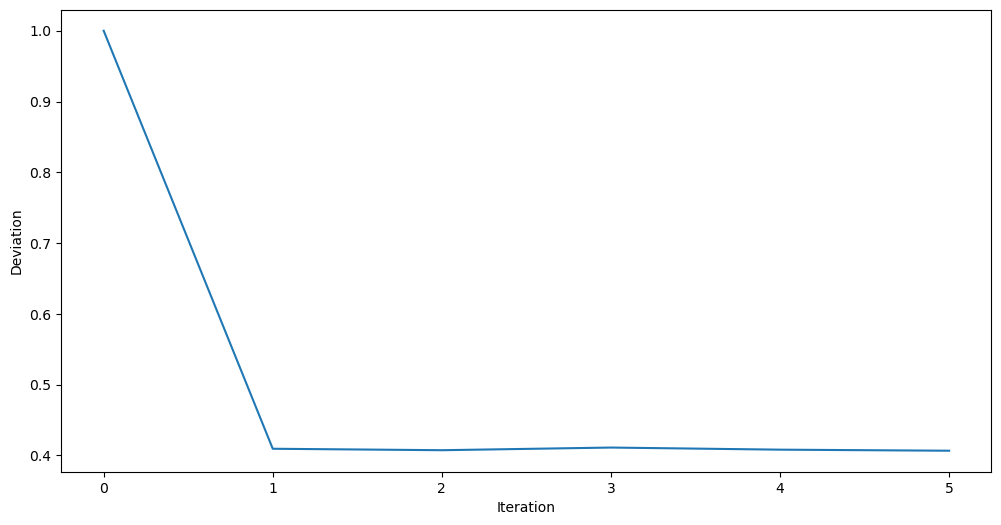

In [10]:
# First analyze deviation

reg_mod.plot_deviations()

**Clarification**: The deviation between a regularized semivariogram and a theoretical model decreases. However, a significant improvement can be seen after the first step, and then it slows down. That's why semivariogram regularization usually does not require many steps. However, if there are many lags, optimization may require more steps to achieve a meaningful result.

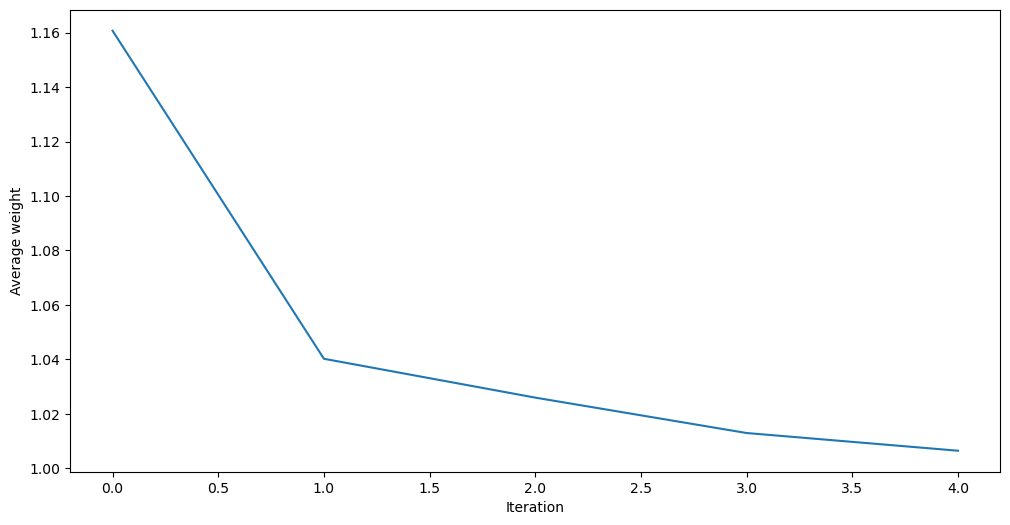

In [11]:
# Check weights - it is important to track problems with algorithm, esepcially if sum of weights is oscillating
# then it may be a sign of problems with data, model or (hopefully not!) algorithm itself.

reg_mod.plot_weights()

**NOTE**: Weights are smaller with each iteration. It is the expected behavior of the algorithm. The general trend goes downward, and small oscillations may occur due to the optimization process.

The most important part is to compare semivariograms! You can see that the Regularized Model is different from the initial semivariogram. It is the result of regularization. The population (point support) is considered in the cases of variogram development and further kriging interpolation.

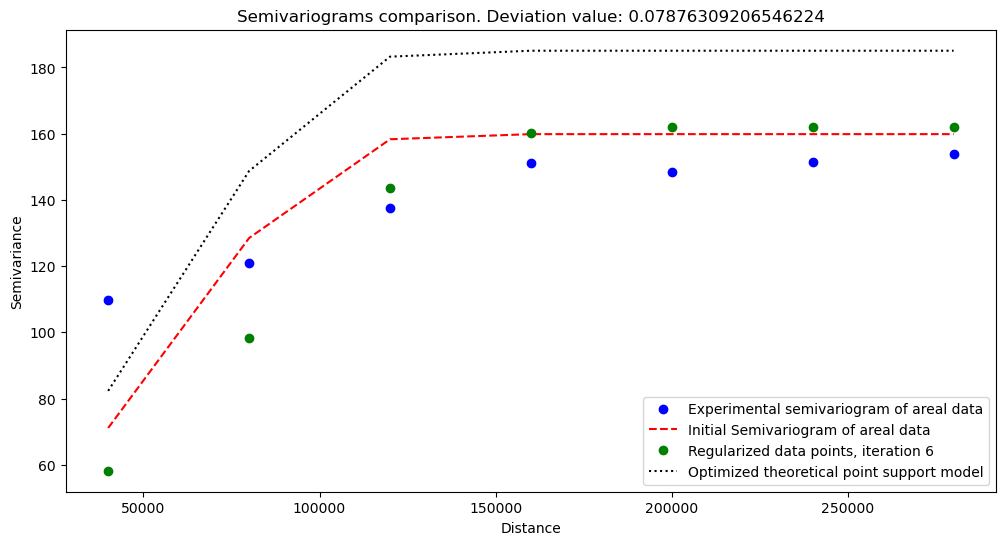

In [12]:
reg_mod.plot_variograms()

The regularized model works well for our dataset and follows general trends. It assigns smaller weights for closest lags, and for more significant distances, weights are bigger. It is related to the semivariogram weighting method - we penalize more poorly performing models for the shortest distances from the origin.

## 5) Export semivariogram to text file

In [13]:
# Export semivariogram to the text file. This is important step because calculations are slow...
# and it is better to not repeat them.
# We will use built-in method: export_model() where we pass only filename and our semivariogram
# parameters are stored for other tasks.
reg_mod.export_model('output/regularized_model.json')

---

## Where to go from here?

* C.1.3 Poisson Kriging Centroid-based
* C.1.4 Poisson Kriging Area to Area
* C.1.5 Poisson Kriging Area to Point

## Changelog

| Date       | Change description                                                                                                    | Author |
|------------|-----------------------------------------------------------------------------------------------------------------------|--------|
| 2023-08-24 | The tutorial was refreshed and set along with the 0.5.0 version of the package                                                                                    | @SimonMolinsky |
| 2023-04-15 | Tutorial debugged and updated to the 0.4.1 version of the package                                                     | @SimonMolinsky |
| 2022-11-05 | Tutorial updated for the 0.3.5 version of the package                                                                 | @SimonMolinsky |
| 2022-10-08 | Update for the 0.3.4 version of the package                                                                           | @SimonMolinsky |
| 2022-10-17 | Updated variogram models selection (0.3.3 version of the package)                                                     | @SimonMolinsky |
| 2022-10-08 | Update for the 0.3.2 version of the package                                                                           | @SimonMolinsky |
| 2022-08-27 | Update for the 0.3.0 version of the package                                                                           | @SimonMolinsky |
| 2021-12-14 | Sill selection was upgraded: now optimal sill is derived from the grid search within `TheoreticalSemivariogram` class | @SimonMolinsky |
| 2021-12-13 | Changed behavior of `select_values_in_range()` function                                                               | @SimonMolinsky |
| 2021-05-28 | Updated paths for input/output data                                                                                   | @SimonMolinsky |
| 2021-05-11 | Refactored TheoreticalSemivariogram class                                                                             | @SimonMolinsky |
| 2021-04-04 | Ranges parameter removed from regularize semivariogram class                                                          | @SimonMolinsky |
| 2021-03-31 | Update related to the change of semivariogram weighting. Updated cancer rates data.                                   | @SimonMolinsky |